<a href="https://colab.research.google.com/github/ljpetkovic/Charcot_KeyBERT_Keyphrase-Vectorizers/blob/main/scripts/KeyBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extraction des mots/phrases-clés avec `keybert` et `keyphrase-vectorizers`
### Approche _PatternRank_
###### [Schopf _et al._, 2022](https://arxiv.org/pdf/2210.05245.pdf)
---

#1️⃣ `keybert`
* _cf._ [Grootendorst (2020)](https://doi.org/10.5281/zenodo.4461265)
* librairie Python pour extraire des mots/phrases-clés les plus similaires à un document en exploitant les plongements BERT<br>
⚠️ on doit spécifier la longueur des n-grammes à extraire, alors que l'on ne sait pas quelle est la longueur optimale ;<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`keyphrase_ngram_range=(1, 3)` : on veut extraire trois types de séquences : uni-, bi- ou trigrammes <br>
⚠️ la grammaticalité des phrases n'est pas prise en compte (p. ex. « scientifique les planches »)

**_Maximal Marginal Relevance_**

* Afin de diversifier les résultats de l'extraction des mots / phrases-clés, on peut utiliser _Maximal Margin Relevance_ (_MMR_), paramètre également basé sur la similarité cosinus :
 * `use_mmr=True, diversity=[0-1]` (le degré de diversité entre 0 et 1)



 **Mots vides**

 Les listes de mots vides proviennent du vectorizer utilisé avec KeyBERT, et non pas de KeyBERT en soi.

 * `stop_words=None` : si aucune liste ne s'applique
 * `stop_words='french'` : si l'on applique une liste de mots vides en français

In [ ]:
!pip install keybert
!pip install nltk
!pip install spacy
import torch
import os
from sentence_transformers import SentenceTransformer
from keybert import KeyBERT
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import spacy

from google.colab import drive
# Monter le Google Drive
drive.mount('/content/drive')

# Initialize the Sentence Transformer Model
sentence_model = SentenceTransformer("distiluse-base-multilingual-cased-v1")
kw_model = KeyBERT(model=sentence_model)

# Download and set up French stop words
## si spaCy

# Load spaCy French model
!python -m spacy download fr_core_news_lg
nlp = spacy.load('fr_core_news_lg')
# Convert spaCy's set of stop words to a list
french_stop_words = list(nlp.Defaults.stop_words)


## si NLTK
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# french_stop_words = stopwords.words('french')

# Initialize CountVectorizer with French stop words
vectorizer = CountVectorizer(ngram_range=(1, 3), stop_words=french_stop_words)

# Assuming Google Drive is mounted and paths are correctly set up
path = '/content/drive/MyDrive/ObTIC/ateliers/extraction_mots_cles/corpus/'
file_name = 'echantillon_charcot.txt'
file_path = '../output/keybert_charcot_output.txt'

# Function to sort keywords
def sort_keywords_by_score(keywords):
    # Sort keywords based on the score in descending order
    return sorted(keywords, key=lambda x: x[1], reverse=True)

# List to store all keywords
all_keywords = []

# Extract keywords from the file
with open(os.path.join(path, file_name), 'r') as myfile:
    raw_data = myfile.readlines()
    start = 0
    end = 20
    while len(raw_data) >= end:
        data = " ".join(raw_data[start:end])
        start = end
        end += 20
        keywords = kw_model.extract_keywords(data, vectorizer=vectorizer, use_mmr=True, diversity=0.7)
        all_keywords.extend(keywords)

# Sort all keywords once after extraction
sorted_keywords = sort_keywords_by_score(all_keywords)

# Write sorted keywords to the output file
with open(os.path.join(path, file_path), 'w') as outfile:
    for keyword, score in sorted_keywords:
        print(f"{keyword}: {score}")
        outfile.write(f"{keyword}: {score}\n")


## Répartition des 15 premiers termes avec `keybert`

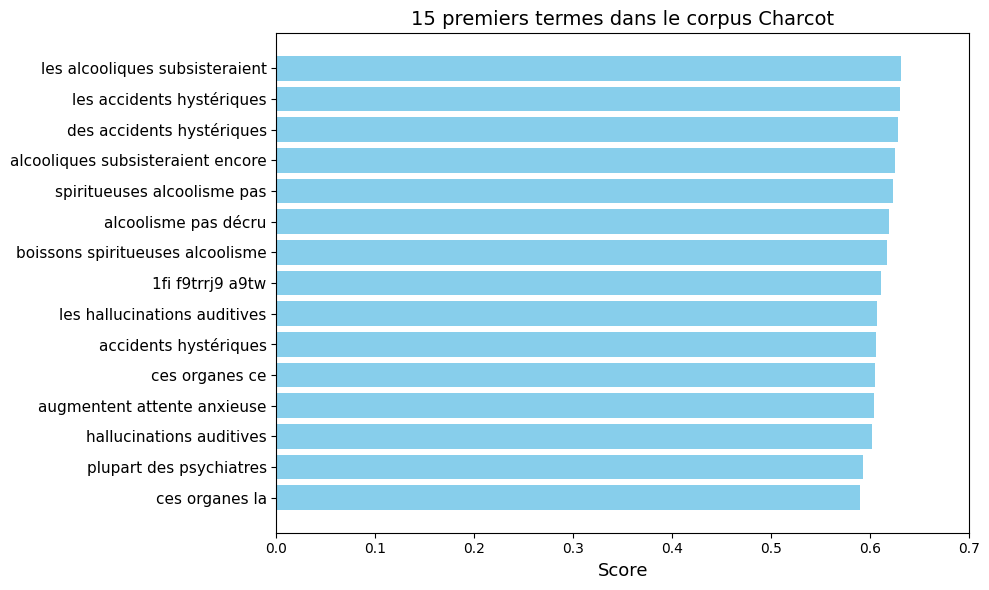

In [18]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Charger les données depuis le fichier CSV
df = pd.read_csv("charcot_keybert_complet.csv")

# Trier par score décroissant et garder les 15 premiers termes
top15 = df.sort_values(by="score", ascending=False).head(15)

# Créer la figure
plt.figure(figsize=(10, 6))
plt.barh(top15["Phrase-clé"], top15["score"], color="skyblue")
plt.gca().invert_yaxis()

# Axe des X avec ticks réguliers de 0 à 0.7
tick_values = np.arange(0, 0.71, 0.1)
plt.xticks(tick_values, [f"{v:.1f}" for v in tick_values])
plt.xlim(0, 0.7)

# Étiquettes et titre
plt.xlabel("Score", fontsize=13)
plt.yticks(fontsize=11)
plt.title("15 premiers termes dans le corpus Charcot", fontsize=14)

# Mise en page et affichage
plt.tight_layout()
plt.savefig("top15_charcot_keybert.png", dpi=300)
plt.show()


#2️⃣ PatternRank
* `keybert` + **`keyphrase-vectorizers`** = PatternRank<br>
 ❇️ pas besoin de spécifier la longueur des n-grammes à extraire, car la librairie l'infère elle-même<br>
❇️ la grammaticalité des phrases est prise en compte grâce aux extractions des parties du discours (p. ex. `<N.*>*<ADJ.*>*<ADJ.*>+`--> _sclérose latérale amyotrophique_)
* _cf._ [Schopf _et al._ (2022)](https://arxiv.org/pdf/2210.05245.pdf) et [Schopf (2022)](https://towardsdatascience.com/enhancing-keybert-keyword-extraction-results-with-keyphrasevectorizers-3796fa93f4db)



# Script optimisé en mémoire et sans utiliser des mots vides
Date de dernière modification : 31/07/2025

In [ ]:
#!pip install keyphrase-vectorizers
#!pip install keybert
#!pip install flair
#!pip install spacy
#!python -m spacy download fr_core_news_lg


import glob
import os
import csv
from keybert import KeyBERT
from keyphrase_vectorizers import KeyphraseCountVectorizer
from flair.embeddings import TransformerDocumentEmbeddings
import spacy

# Mount Google Drive
# from google.colab import drive
# Monter le Google Drive
# drive.mount('/content/drive')

# Load the spaCy model
nlp = spacy.load("fr_core_news_lg")

# Convert spaCy's stop words to a list
# french_stop_words = list(nlp.Defaults.stop_words)

# Set input/output paths
input_path = "/content/drive/MyDrive/ObTIC/Charcot/Keyphrase-Vectorizers/corpus/txt_corpus_Charcot/"
output_file_name = "/content/drive/MyDrive/ObTIC/Charcot/Keyphrase-Vectorizers/output/charcot_020825/CO_000092_010_texte.csv"

# Use CamemBERT model (best for French)
kw_model = KeyBERT(model=TransformerDocumentEmbeddings("camembert-base"))

vectorizer = KeyphraseCountVectorizer(
    spacy_pipeline=nlp,
    pos_pattern=(
       # "<NOUN>+"                                 # NOM ou plusieurs NOM
        "<NOUN>+<NOUN>+"                         # NOM + NOM
        "|<NOUN>+<ADJ>+"                          # NOM + ADJ
        "|<NOUN>+<ADJ>+<ADJ>*"                    # NOM + plusieurs ADJ
        "|<NOUN>+<ADP><NOUN>+"                    # NOM + PRÉP + NOM
        "|<NOUN>+<ADP><NOUN>+<ADJ>*"              # NOM + PRÉP + NOM + (ADJ*)
        "|<NOUN>+<ADP><NOUN>+<ADJ>+<ADJ>*"        # NOM + PRÉP + NOM + plusieurs ADJ
    )
    # stop_words=french_stop_words
)


# Get all .txt files in the input directory
input_files = glob.glob(os.path.join(input_path, "CO_000092_010_texte.txt"))

# Open CSV file for writing
with open(output_file_name, "w", encoding="utf-8", newline="") as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=";")
    csv_writer.writerow(["Filename", "Keyphrase", "Score"])  # Header row

    # Process each file in the directory
    for input_file_name in input_files:
        print(f"Processing file: {input_file_name}")

        with open(input_file_name, "r", encoding="utf-8") as input_file:
            buffer = []  # Temporary storage for processing
            line_count = 0  # Track lines processed

            for line in input_file:
                if line.strip():  # Avoid empty lines
                    buffer.append(line.strip())  # Store line in buffer
                    line_count += 1

                if line_count % 500 == 0 and buffer:  # Process every 500 lines
                    data = " ".join(buffer)  # Convert buffer to a string
                    buffer = []  # Clear buffer after processing

                    try:
                        keyphrases = kw_model.extract_keywords(data, vectorizer=vectorizer)
                        if keyphrases:  # Ensure we have extracted phrases
                            for phrase, score in keyphrases:
                                csv_writer.writerow([os.path.basename(input_file_name), phrase, f"{score:.4f}"])
                    except ValueError as e:
                        print(f"Error processing {input_file_name} at line {line_count}: {e}")

            # Process any remaining lines in the buffer
            if buffer:
                data = " ".join(buffer)
                try:
                    keyphrases = kw_model.extract_keywords(data, vectorizer=vectorizer)
                    if keyphrases:  # Ensure we have extracted phrases
                        for phrase, score in keyphrases:
                            csv_writer.writerow([os.path.basename(input_file_name), phrase, f"{score:.4f}"])
                except ValueError as e:
                    print(f"Error processing {input_file_name} at end of file: {e}")

print(f"✅ Keyphrases saved to {output_file_name}")

Processing file: /content/drive/MyDrive/ObTIC/Charcot/Keyphrase-Vectorizers/corpus/txt_corpus_Charcot/CO_000092_010_texte.txt
✅ Keyphrases saved to /content/drive/MyDrive/ObTIC/Charcot/Keyphrase-Vectorizers/output/charcot_020825/CO_000092_010_texte.csv


# Bloopers

In [ ]:
#!pip install keyphrase-vectorizers
#!pip install keybert
#!pip install flair
#!pip install spacy
#!python -m spacy download fr_core_news_lg

import glob
import os
from keybert import KeyBERT
from keyphrase_vectorizers import KeyphraseCountVectorizer
from flair.embeddings import TransformerDocumentEmbeddings
import spacy

# Mount Google Drive
from google.colab import drive
# Monter le Google Drive
drive.mount('/content/drive')

# Load the spaCy model
nlp = spacy.load("fr_core_news_lg")

# Convert spaCy's stop words to a list
french_stop_words = list(nlp.Defaults.stop_words)

# Set paths
path = "/content/drive/MyDrive/ObTIC/Charcot/Keyphrase-Vectorizers/corpus/txt_corpus_Autres/"
output_file_name = "/content/drive/MyDrive/ObTIC/Charcot/Keyphrase-Vectorizers/output/CA_000003_001_texte_500.csv"

# Use camembert model
kw_model = KeyBERT(model=TransformerDocumentEmbeddings("camembert-base"))

# Setup vectorizer with a well-formed pattern
vectorizer = KeyphraseCountVectorizer(
    spacy_pipeline=nlp,
    pos_pattern=(
        "<N.*><ADJ.*>*|"  # NOUN + optional ADJECTIVE(s)
        "<N.*><P.*><N.*><ADJ.*>*"  # NOUN + PREPOSITION + NOUN + optional ADJECTIVE(s)
    ),
    stop_words=french_stop_words
)

# Read and process the file efficiently
input_file_name = "CA_000003_001_texte.txt"
full_input_path = os.path.join(path, input_file_name)

if not os.path.exists(full_input_path):
    raise FileNotFoundError(f"❌ ERROR: File not found - {full_input_path}")

with open(full_input_path, "r", encoding="utf-8") as input_file:
    raw_data = input_file.readlines()

# Write to file while processing instead of keeping everything in memory
with open(os.path.join(path, output_file_name), "w", encoding="utf-8") as output_file:
    for start in range(0, len(raw_data), 500):  # Process 500 lines at a time
        data = " ".join(raw_data[start:start+500]).replace("\n", " ")
        try:
            keyphrases = kw_model.extract_keywords(data, vectorizer=vectorizer)
            for phrase, score in keyphrases:
                output_file.write(f"{phrase}; {score:.4f}\n")
        except ValueError as e:
            print(f"An error occurred at chunk starting at line {start}: {e}")

print(f"✅ Keyphrases saved to {output_file_name}")


In [ ]:
#!pip install keyphrase-vectorizers
#!pip install keybert
#!pip install flair
#!pip install spacy
#!python -m spacy download fr_core_news_lg


import glob
import os
import csv
from keybert import KeyBERT
from keyphrase_vectorizers import KeyphraseCountVectorizer
from flair.embeddings import TransformerDocumentEmbeddings
import spacy

# Mount Google Drive
from google.colab import drive
# Monter le Google Drive
drive.mount('/content/drive')

# Load the spaCy model
nlp = spacy.load("fr_core_news_lg")

# Convert spaCy's stop words to a list
french_stop_words = list(nlp.Defaults.stop_words)

# Set input/output paths
input_path = "/content/drive/MyDrive/ObTIC/Charcot/Keyphrase-Vectorizers/corpus/txt_corpus_Autres/"
output_file_name = "/content/drive/MyDrive/ObTIC/Charcot/Keyphrase-Vectorizers/output/ALL_KEYPHRASES_apartir_CP_000001_001_texte.txt.csv"

# Use CamemBERT model (best for French)
kw_model = KeyBERT(model=TransformerDocumentEmbeddings("camembert-base"))

# Setup vectorizer with a well-formed pattern
vectorizer = KeyphraseCountVectorizer(
    spacy_pipeline=nlp,
    pos_pattern=(
        "<N.*><ADJ.*>*|"  # NOUN + optional ADJECTIVE(s)
        "<N.*><P.*><N.*><ADJ.*>*"  # NOUN + PREPOSITION + NOUN + optional ADJECTIVE(s)
    ),
    stop_words=french_stop_words
)

# Get all .txt files in the input directory
input_files = glob.glob(os.path.join(input_path, "*.txt"))

# Open CSV file for writing
with open(output_file_name, "w", encoding="utf-8", newline="") as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=";")
    csv_writer.writerow(["Filename", "Keyphrase", "Score"])  # Header row

    # Process each file in the directory
    for input_file_name in input_files:
        print(f"Processing file: {input_file_name}")

        with open(input_file_name, "r", encoding="utf-8") as input_file:
            buffer = []  # Temporary storage for processing
            line_count = 0  # Track lines processed

            for line in input_file:
                if line.strip():  # Avoid empty lines
                    buffer.append(line.strip())  # Store line in buffer
                    line_count += 1

                if line_count % 500 == 0 and buffer:  # Process every 500 lines
                    data = " ".join(buffer)  # Convert buffer to a string
                    buffer = []  # Clear buffer after processing

                    try:
                        keyphrases = kw_model.extract_keywords(data, vectorizer=vectorizer)
                        if keyphrases:  # Ensure we have extracted phrases
                            for phrase, score in keyphrases:
                                csv_writer.writerow([os.path.basename(input_file_name), phrase, f"{score:.4f}"])
                    except ValueError as e:
                        print(f"Error processing {input_file_name} at line {line_count}: {e}")

            # Process any remaining lines in the buffer
            if buffer:
                data = " ".join(buffer)
                try:
                    keyphrases = kw_model.extract_keywords(data, vectorizer=vectorizer)
                    if keyphrases:  # Ensure we have extracted phrases
                        for phrase, score in keyphrases:
                            csv_writer.writerow([os.path.basename(input_file_name), phrase, f"{score:.4f}"])
                except ValueError as e:
                    print(f"Error processing {input_file_name} at end of file: {e}")

print(f"✅ Keyphrases saved to {output_file_name}")


# 📡 Repérage des phrases-clés communes

In [ ]:
import pandas as pd

def load_dataframe(filepath):
    for sep in [",", ";", "\t"]:
        try:
            df = pd.read_csv(filepath, sep=sep)
            if "Keyphrase" in df.columns and "Score" in df.columns:
                df = df[df["Keyphrase"] != "Keyphrase"]
                df["Keyphrase"] = df["Keyphrase"].str.strip().str.lower()
                df["Score"] = pd.to_numeric(df["Score"], errors="coerce")
                df = df.dropna(subset=["Score"])
                return df
        except Exception:
            continue
    raise ValueError("Format de fichier inconnu ou séparateur incorrect.")

# Chemins d'entrée
charcot_file = "charcot_kpv_060825.csv"
autres_file = "autres_echantillon_kpv_060825.csv"

# Chargement des DataFrames
charcot_df = load_dataframe(charcot_file)
autres_df = load_dataframe(autres_file)

# Moyennes des scores par keyphrase
charcot_scores = charcot_df.groupby("Keyphrase")["Score"].mean().rename("Score_Charcot")
autres_scores = autres_df.groupby("Keyphrase")["Score"].mean().rename("Score_Autres")

# Termes en commun
common_terms = set(charcot_scores.index) & set(autres_scores.index)

# Fusion
merged = pd.concat([charcot_scores, autres_scores], axis=1).loc[list(common_terms)]
merged["Score_Moyen"] = merged[["Score_Charcot", "Score_Autres"]].mean(axis=1)

# Arrondi des scores
merged = merged.round(3)

# Tri décroissant par score moyen
merged_sorted = merged.sort_values(by="Score_Moyen", ascending=False).reset_index()

# Sauvegarde
merged_sorted.to_csv("termes_en_commun.csv", index=False)
print("Fichier 'termes_en_commun.csv' généré avec scores arrondis à 3 décimales.")


Fichier 'termes_en_commun.csv' généré avec scores arrondis à 3 décimales.


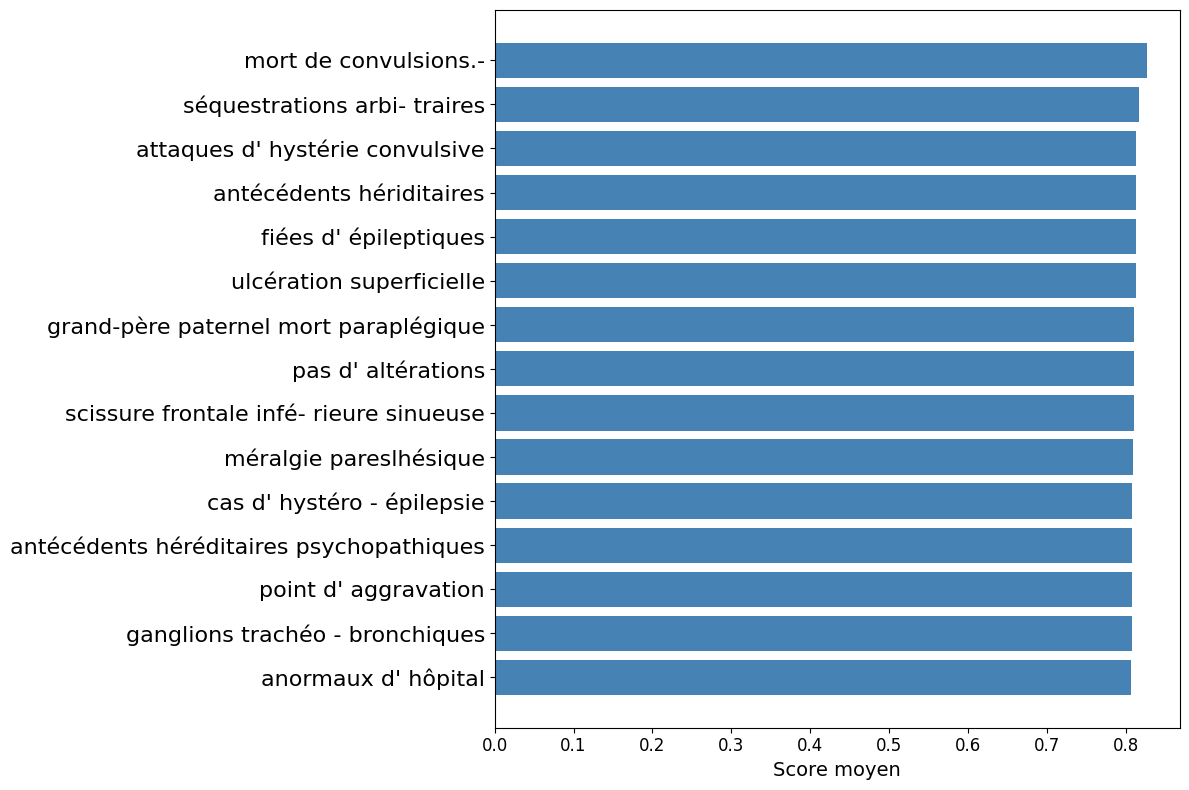

Fichier 'top15_termes_communs.png' sauvegardé avec succès.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger les données
df = pd.read_csv("termes_en_commun.csv")

# Garder les 15 meilleurs termes par score moyen
top15 = df.sort_values(by="Score_Moyen", ascending=False).head(15)

# Créer le graphique
plt.figure(figsize=(12, 8))
bars = plt.barh(top15["Keyphrase"], top15["Score_Moyen"], color="steelblue")

# Mise en forme
plt.xlabel("Score moyen", fontsize=14)
# plt.title("Top 15 des termes communs (score moyen le plus élevé)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.gca().invert_yaxis()
plt.tight_layout()

# Sauvegarde en haute résolution
plt.savefig("top15_termes_communs.png", dpi=300)
plt.show()
print("Fichier 'top15_termes_communs.png' sauvegardé avec succès.")


In [ ]:
# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
import re
import numpy as np
pattern = re.compile(r":.*\n")
charcot_pr = "/content/drive/MyDrive/ObTIC/ateliers/extraction_mots_cles/output/charcot_output.txt"
autres_pr = "/content/drive/MyDrive/ObTIC/ateliers/extraction_mots_cles/output/autres_output.txt"



# N'extraire que des phrases-clés, sans leurs scores
with open(charcot_pr, 'r') as input_file_charcot, open(autres_pr, 'r') as input_file_autres:
    raw_data_charcot = input_file_charcot.readlines()
    raw_data_autres = input_file_autres.readlines()
    res_charcot = [pattern.sub("", match) for match in raw_data_charcot]
    res_autres = [pattern.sub("", match) for match in raw_data_autres]
    # for r in res_charcot:
      # print(r)
    # for r2 in res_autres:
    #   print(r2)

    common_elements = np.intersect1d(res_charcot, res_autres)
    celem_list = common_elements.tolist()
    for c in celem_list:
      print(c)



In [ ]:
!pip install yake

In [ ]:
import re
from yake import KeywordExtractor

# Fichier à analyser
file_path = "/content/oai_persee_article_noroi_0029-182x_1955_num_6_1_1077.txt"

# Configuration de YAKE pour le français
extractor = KeywordExtractor(lan="fr", top=10)

# Lecture du fichier
with open(file_path, 'r', encoding='utf-8') as f:
    text = f.read()

# Nettoyage du texte
text = re.sub(r'\s+', ' ', text)  # Suppression des espaces multiples
text = re.sub(r'\[.*?\]', '', text)  # Suppression des références

# Extraction des mots-clés
keywords = extractor.extract_keywords(text)

# Formatage des résultats
kw_list = [kw[0].lower() for kw in keywords if len(kw[0]) > 3]  # Filtre les termes courts

print("Termes clés extraits :")
for i, term in enumerate(set(kw_list)):  # Élimination des doublons
    print(f"{i+1}. {term}")

In [ ]:
!pip install keyphrase-vectorizers keybert flair spacy
!python -m spacy download fr_core_news_lg

from keyphrase_vectorizers import KeyphraseCountVectorizer
from keybert import KeyBERT
from flair.embeddings import TransformerDocumentEmbeddings
import spacy
from collections import defaultdict
import os

# Charger les modèles
nlp = spacy.load("fr_core_news_lg")
kw_model = KeyBERT(model=TransformerDocumentEmbeddings('camembert-base'))

# Configuration du vectorizer
vectorizer = KeyphraseCountVectorizer(
    spacy_pipeline=nlp,
    pos_pattern='<N.+>+<ADJ.*>*<PREP>?<N.+>*',
    stop_words=list(nlp.Defaults.stop_words)
)

# Chemins
drive_path = '/content/drive/MyDrive/ObTIC/ateliers/extraction_mots_cles/corpus/'
input_dir = os.path.join(drive_path, '2000s')  # Dossier contenant les 62 fichiers
output_dir = os.path.join(drive_path, 'output_2000s')  # Dossier de sortie

# Créer le dossier de sortie s'il n'existe pas
os.makedirs(output_dir, exist_ok=True)

# Traiter tous les fichiers .txt du dossier
for filename in os.listdir(input_dir):
    if filename.endswith('.txt'):
        file_path = os.path.join(input_dir, filename)

        try:
            # Lire le fichier
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read().replace('\n', ' ')

            # Lemmatisation
            doc = nlp(text)
            lemmatized_text = " ".join([token.lemma_ for token in doc])

            # Extraction de mots-clés
            keywords = kw_model.extract_keywords(
                lemmatized_text,
                vectorizer=vectorizer,
                keyphrase_ngram_range=(1, 3),
                use_mmr=True,
                diversity=0.7,
                top_n=50
            )

            # Fusion des doublons
            keyword_scores = defaultdict(float)
            for kw, score in keywords:
                keyword_scores[kw] += score

            # Tri par score
            sorted_keywords = sorted(keyword_scores.items(), key=lambda x: x[1], reverse=True)

            # Enregistrer les résultats
            output_path = os.path.join(output_dir, f'keywords_{filename}')
            with open(output_path, 'w', encoding='utf-8') as f:
                for kw, score in sorted_keywords:
                    f.write(f"{kw}: {score}\n")

            print(f"Traitement réussi : {filename}")

        except Exception as e:
            print(f"Erreur avec le fichier {filename} : {str(e)}")
            continue

print("Traitement de tous les fichiers terminé!")